# Your First GAN

### Goal
In this notebook, we are going to create our first generative adversarial network (GAN)! Specifically, we will build and train a GAN that can generate hand-written images of digi

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

#### MNIST Dataset
The training images your discriminator will be using is from a dataset called [MNIST](http://yann.lecun.com/exdb/mnist/). It contains 60,000 images of handwritten digits, from 0 to 9, like these:

![MNIST Digits](MnistExamples.png)

You may notice that the images are quite pixelated -- this is because they are all only 28 x 28! The small size of its images makes MNIST ideal for simple training. Additionally, these images are also in black-and-white so only one dimension, or "color channel", is needed to represent them (more on this later in the course).

#### Tensor
You will represent the data using [tensors](https://pytorch.org/docs/stable/tensors.html). Tensors are a generalization of matrices: for example, a stack of three matrices with the amounts of red, green, and blue at different locations in a 64 x 64 pixel image is a tensor with the shape 3 x 64 x 64.

Tensors are easy to manipulate and supported by [PyTorch](https://pytorch.org/), the machine learning library you will be using. Feel free to explore them more, but you can imagine these as multi-dimensional matrices or vectors!

#### Batches
While you could train your model after generating one image, it is extremely inefficient and leads to less stable training. In GANs, and in machine learning in general, you will process multiple images per training step. These are called batches.

This means that your generator will generate an entire batch of images and receive the discriminator's feedback on each before updating the model. The same goes for the discriminator, it will calculate its loss on the entire batch of generated images as well as on the reals before the model is updated.

## Generator
The first step is to build the generator component.

Start by creating a function to make a single layer/block for the generator's neural network. Each block should include a [linear transformation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) to map to another shape, a [batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) for stabilization, and finally a non-linear activation function (you use a [ReLU here](https://pytorch.org/docs/master/generated/torch.nn.ReLU.html)) so the output can be transformed in complex ways. 

In [2]:
def get_generator_block(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True)
    )

Now we can build the generator class. It will take 3 values:

*   The noise vector dimension
*   The image dimension
*   The initial hidden dimension

Using these values, the generator will build a neural network with 5 layers/blocks. Beginning with the noise vector, the generator will apply non-linear transformations via the block function until the tensor is mapped to the size of the image to be outputted (the same size as the real images from MNIST). You will need to fill in the code for final layer since it is different than the others. The final layer does not need a normalization or activation function, but does need to be scaled with a [sigmoid function](https://pytorch.org/docs/master/generated/torch.nn.Sigmoid.html). 

Finally, we are given a forward pass function that takes in a noise vector and generates an image of the output dimension using your neural network.

<details>

<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">Generator</font></code></b>
</font>
</summary>

1. The output size of the final linear transformation should be im_dim, but remember you need to scale the outputs between 0 and 1 using the sigmoid function.
2. [nn.Linear](https://pytorch.org/docs/master/generated/torch.nn.Linear.html) and [nn.Sigmoid](https://pytorch.org/docs/master/generated/torch.nn.Sigmoid.html) will be useful here. 
</details>


In [4]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim*8, im_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)
    
    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen

In [21]:

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''

    return torch.randn(n_samples, z_dim, device=device)


In [8]:

def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2 
          (https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html)
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(negative_slope=0.2)
    )

In [10]:

class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim,1)
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)
    
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc

In [22]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001

# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=False, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

device = 'cuda'

Now, you can initialize your generator, discriminator, and optimizers. Note that each optimizer only takes the parameters of one particular model, since we want each optimizer to optimize only one of the models.

In [13]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

Before we train our GAN, we will need to create functions to calculate the discriminator's loss and the generator's loss. This is how the discriminator and generator will know how they are doing and improve themselves. Since the generator is needed when calculating the discriminator's loss, we will need to call .detach() on the generator result to ensure that only the discriminator is updated!

Remember that we have already defined a loss function earlier (`criterion`) and you are encouraged to use `torch.ones_like` and `torch.zeros_like` instead of `torch.ones` or `torch.zeros`. If we use `torch.ones` or `torch.zeros`, we'll need to pass `device=device` to them.

In [23]:

def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''

    noise = get_noise(num_images,z_dim, device=device)
    num_images = gen(noise)
    disc_fake_prediction = disc(num_images.detach())
    disc_fake_loss = criterion(disc_fake_prediction,torch.zeros_like(disc_fake_prediction))
    disc_real_prediction = disc(real)
    disc_real_loss = criterion(disc_real_prediction,torch.ones_like(disc_real_prediction))
    disc_loss = (disc_real_loss+disc_fake_loss)/2.0
    return disc_loss

In [17]:
def test_disc_reasonable(num_images=10):
    # Don't use explicit casts to cuda - use the device argument
    import inspect, re
    lines = inspect.getsource(get_disc_loss)
    assert (re.search(r"to\(.cuda.\)", lines)) is None
    assert (re.search(r"\.cuda\(\)", lines)) is None
    
    z_dim = 64
    gen = torch.zeros_like
    disc = lambda x: x.mean(1)[:, None]
    criterion = torch.mul # Multiply
    real = torch.ones(num_images, z_dim)
    disc_loss = get_disc_loss(gen, disc, criterion, real, num_images, z_dim, 'cpu')
    assert torch.all(torch.abs(disc_loss.mean() - 0.5) < 1e-5)
    
    gen = torch.ones_like
    criterion = torch.mul # Multiply
    real = torch.zeros(num_images, z_dim)
    assert torch.all(torch.abs(get_disc_loss(gen, disc, criterion, real, num_images, z_dim, 'cpu')) < 1e-5)
    
    gen = lambda x: torch.ones(num_images, 10)
    disc = lambda x: x.mean(1)[:, None] + 10
    criterion = torch.mul # Multiply
    real = torch.zeros(num_images, 10)
    assert torch.all(torch.abs(get_disc_loss(gen, disc, criterion, real, num_images, z_dim, 'cpu').mean() - 5) < 1e-5)

    gen = torch.ones_like
    disc = nn.Linear(64, 1, bias=False)
    real = torch.ones(num_images, 64) * 0.5
    disc.weight.data = torch.ones_like(disc.weight.data) * 0.5
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
    criterion = lambda x, y: torch.sum(x) + torch.sum(y)
    disc_loss = get_disc_loss(gen, disc, criterion, real, num_images, z_dim, 'cpu').mean()
    disc_loss.backward()
    assert torch.isclose(torch.abs(disc.weight.grad.mean() - 11.25), torch.tensor(3.75))
    
def test_disc_loss(max_tests = 10):
    z_dim = 64
    gen = Generator(z_dim).to(device)
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
    disc = Discriminator().to(device) 
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
    num_steps = 0
    for real, _ in dataloader:
        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradient before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        assert (disc_loss - 0.68).abs() < 0.05

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Check that they detached correctly
        assert gen.gen[0][0].weight.grad is None

        # Update optimizer
        old_weight = disc.disc[0][0].weight.data.clone()
        disc_opt.step()
        new_weight = disc.disc[0][0].weight.data
        
        # Check that some discriminator weights changed
        assert not torch.all(torch.eq(old_weight, new_weight))
        num_steps += 1
        if num_steps >= max_tests:
            break

test_disc_reasonable()
test_disc_loss()
print("Success!")


Success!


In [24]:

def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''

    noise = get_noise(num_images, z_dim, device=device)
    fake = gen(noise)
    disc_prediction = disc(fake)
    gen_loss = criterion(disc_prediction, torch.ones_like(disc_prediction))
    return gen_loss

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 1.1561411178112013, discriminator loss: 0.5034350275993351


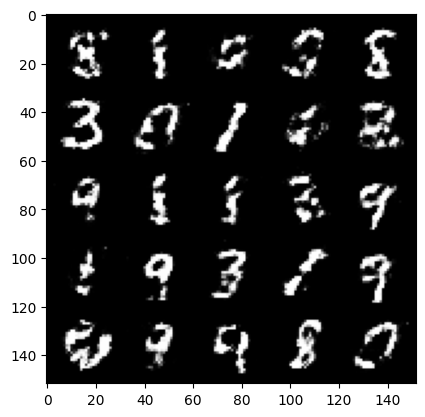

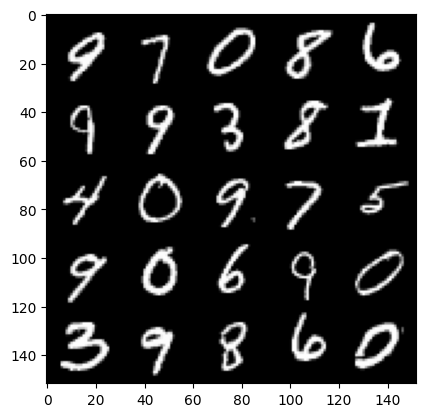

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 1.2075421867370615, discriminator loss: 0.49112774121761327


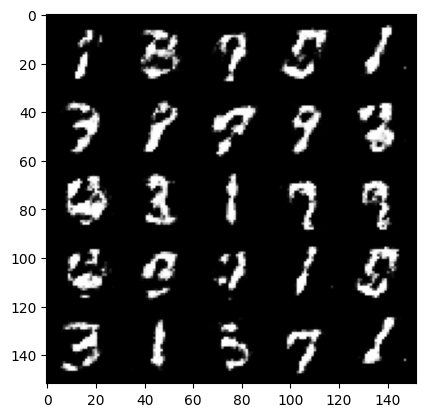

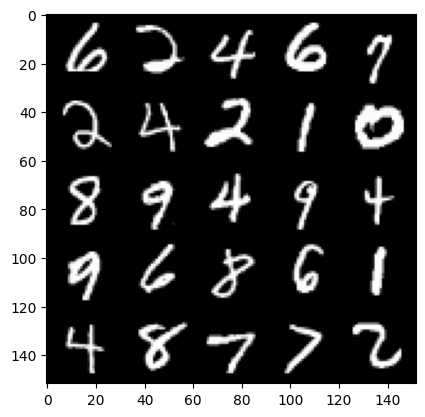

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 1.228119808912276, discriminator loss: 0.4841955135464672


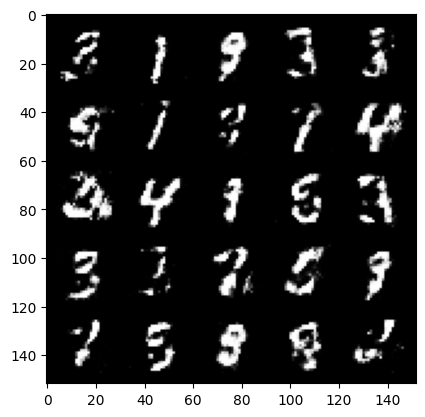

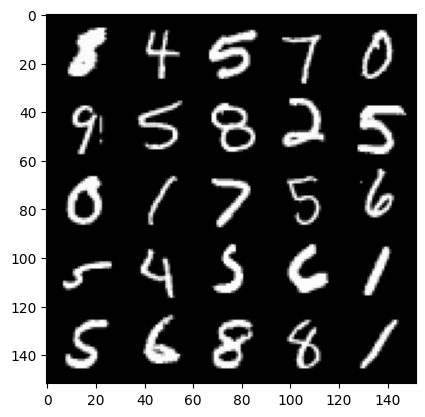

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.1388150434494015, discriminator loss: 0.5160755388736725


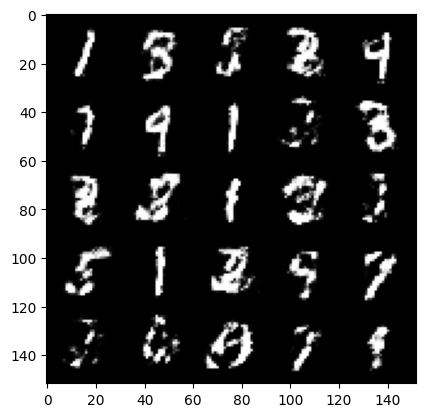

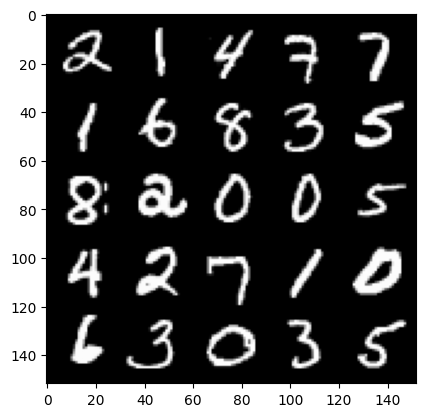

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 1.176674691677094, discriminator loss: 0.49704634535312686


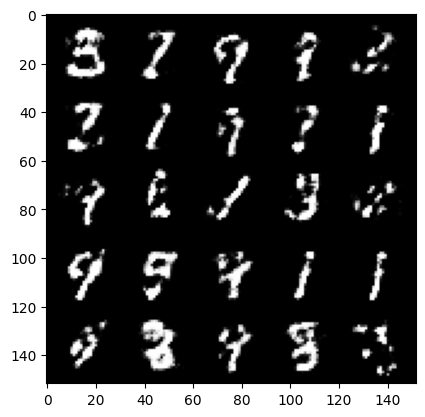

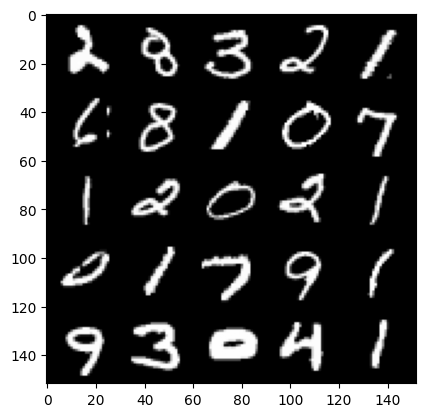

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 1.115765657901764, discriminator loss: 0.5201429969668394


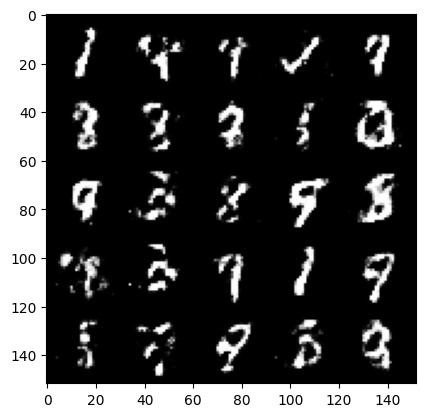

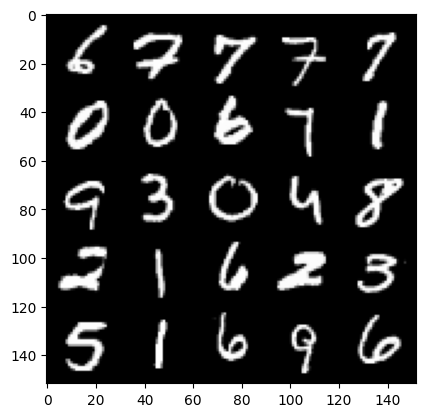

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 1.1720964144468324, discriminator loss: 0.509893209040165


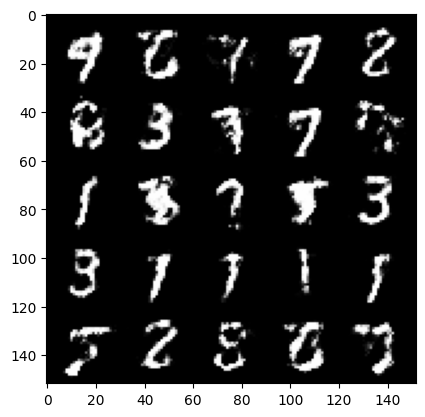

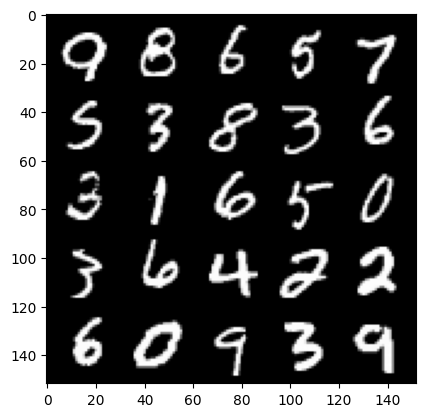

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 1.0861049721240992, discriminator loss: 0.5312376238703723


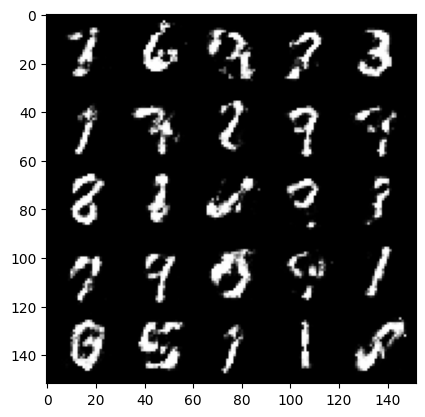

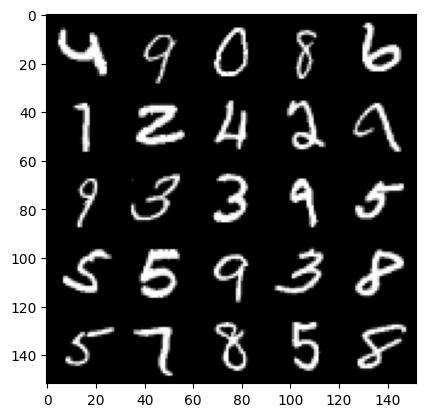

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 1.0376741495132447, discriminator loss: 0.5534932857751849


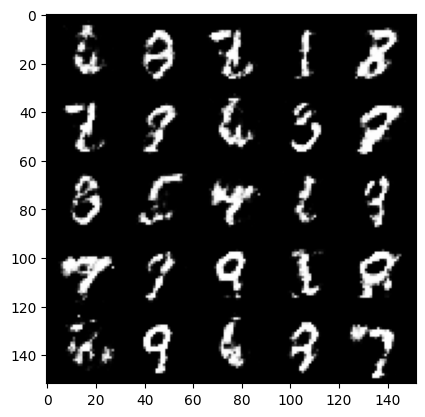

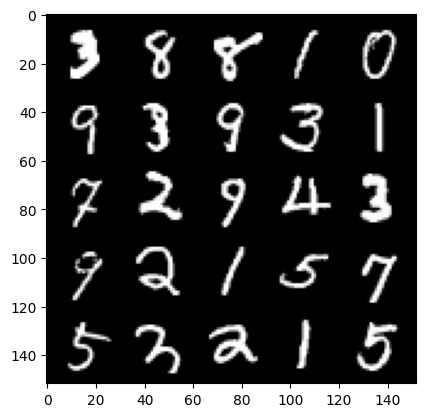

In [26]:

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = False # Whether the generator should be tested
gen_loss = False
error = False
for epoch in range(10):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()

        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
